In [1]:
!pip install nltk
!pip install wordcloud
!pip install spacy


In [2]:
import re
import nltk
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# تجاهل التحذيرات أثناء تنفيذ الكود
warnings.filterwarnings('ignore')

In [3]:
# قراءة ملف CSV مضغوط وتخزينه في DataFrame مع استخدام الترميز ISO-8859-1
# نستخدم "on_bad_lines='skip'" لتجاهل أي أسطر فيها مشاكل أثناء القراءة
# "engine='python'" يمكن يكون ضروري للتعامل مع الملفات الكبيرة أو الصيغ المختلفة
df = pd.read_csv('training_1600000_processed_noemoticon.csv.zip', encoding="ISO-8859-1", header=None, on_bad_lines='skip', engine='python')

# تعيين أسماء الأعمدة في DataFrame لتكون واضحة وسهلة الاستخدام
df.columns = ["sentiment", "id", "date", "flag", "user", "text"]

# تحويل القيم في عمود 'sentiment' من أرقام إلى نصوص (Negative و Positive)
df['sentiment'] = df['sentiment'].map({0: "Negative", 4: "Positive"})

# عرض أول 5 صفوف من DataFrame للتحقق من البيانات
df.head()


,sentiment,id,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# نختار الميزات المهمة من DataFrame، هنا نحتفظ فقط بعمودي "sentiment" و "text"
df = df[['sentiment', 'text']]

# عرض أول 5 صفوف من DataFrame بعد اختيار الميزات للتحقق من البيانات
df.head()


,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [6]:
# shape
df.shape

(1600000, 2)

In [7]:
# information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  object
 1   text       1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


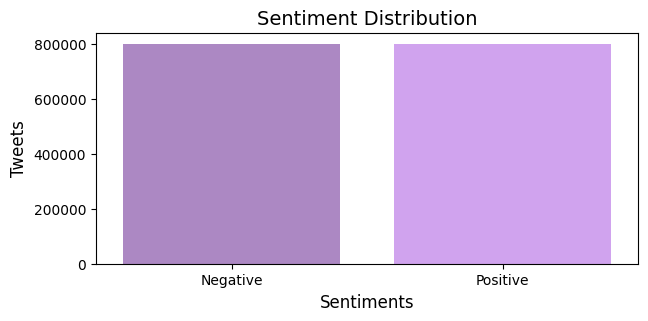

In [8]:
# نبدأ بإنشاء مخطط لتوزيع البيانات الإيجابية والسلبية
plt.figure(figsize=(7, 3))  # نحدد حجم المخطط

# نختار ألوان داكنة للمخطط باستخدام لوحة ألوان داكنة من Seaborn
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')

# نرسم مخطط شريطي يوضح عدد التغريدات لكل نوع من المشاعر (إيجابي وسلبي)
# "palette=[colors[7], colors[9]]" يعطي لون مختلف لكل نوع من المشاعر
sns.countplot(data=df, x='sentiment', palette=[colors[7], colors[9]])

# نسمي المحور السيني "Sentiments" ليعرض نوع الشعور (إيجابي أو سلبي) ونكبر حجم الخط
plt.xlabel("Sentiments", size=12)

# نسمي المحور الصادي "Tweets" ليعرض عدد التغريدات ونكبر حجم الخط
plt.ylabel('Tweets', size=12)

# نضيف عنوان للمخطط يوضح محتواه ونكبر حجم الخط
plt.title("Sentiment Distribution", size=14)

# نعرض المخطط
plt.show()


In [9]:
# تحليل عينة عشوائية من النصوص في البيانات
import random

# ننشئ قائمة تحتوي على 10 أرقام عشوائية تمثل مؤشرات (صفوف) من DataFrame
# نستخدم random.randint لاختيار أرقام عشوائية بين 0 وعدد الصفوف -1
random_index = [random.randint(0, df.shape[0] - 1) for i in range(10)]

# نطبع النصوص من DataFrame باستخدام المؤشرات العشوائية
# هنا نختار عمود 'text' باستخدام المؤشرات العشوائية اللي أنشأناها
for i in df['text'].iloc[random_index]:
    print(i)


Well that's the last of the Fabs gone 
@Maddie_Brady Why no puppies? 
going to work  
@dena33 Happy to be your number 200! 
So, I didn't get a call from @gabrielsaporta and that's pretty sad  But I still love you Gabe! You'll know me when I'm famous. Wait &amp; see.
Uggghhh... Dunno what to wear 
Cleaning my room. Its like a bomb hit it. Hopefully the money box will turn up 
If you havent seen this yet, get ready to laugh out loud.  http://bit.ly/NKmCl
@alexisamore I can't find him today drove around trying to find him. 
@NKOTB_Ottawa You do? OMG Yay! I really want I like it like that! I'll DM my email. THANK YOU SO MUCH!!!!!! 


In [10]:
# جميع الأنماط المستخدمة في تحليل النصوص

# نمط لمطابقة الإشارات (الكلمات التي تبدأ بـ @ و #)، مثل أسماء المستخدمين أو الهاشتاقات
mention_pattern = r'@\S+|#\S+'

# نمط لمطابقة الروابط (التي تبدأ بـ http أو https)
url_pattern = r"https?:(?:www\.)?\S+"

# نمط لمطابقة الأحرف غير الأبجدية الرقمية (بما في ذلك علامات الترقيم)
# هذا النمط يساعد في إزالة الرموز غير الأحرف والأرقام
non_alphanumeric_pattern = r"[^A-Za-z0-9\s]+"


In [11]:
# دالة لتنظيف البيانات النصية
def data_cleaning(text):
    # تحويل النص إلى حروف صغيرة لتوحيد الشكل
    lower_text = str.lower(text)
    
    # إزالة جميع البيانات غير الضرورية مثل الإشارات، الروابط، والرموز باستخدام الأنماط المعرفة مسبقًا
    clean_text = re.sub(mention_pattern + '|' + url_pattern + '|' + non_alphanumeric_pattern, ' ', lower_text)
    
    # إرجاع النص بعد التنظيف
    return clean_text


In [12]:
#  عملية تنظيف البيانات
df['text'] = df['text'].apply(data_cleaning)

In [13]:
import re
from tqdm import tqdm

# دالة بسيطة لتقسيم النص إلى كلمات باستخدام التعبيرات النمطية (regex)
def simple_tokenize(text):
    # إزالة أي رموز غير الحروف والأرقام وتقطيع النص إلى كلمات
    tokens = re.findall(r'\b\w+\b', text.lower())  # تحويل النص إلى أحرف صغيرة وتجزئة بناءً على الكلمات
    return tokens

# استخدام tqdm لإظهار شريط تقدم مع pandas أثناء تطبيق الدالة
tqdm.pandas()

# تطبيق الدالة على العمود 'text' مع شريط التقدم
# نقوم باستخدام دالة lambda مع document.strip() لإزالة أي فراغات زائدة قبل تقسيم النص
df['tokenized text'] = df['text'].progress_apply(lambda document: simple_tokenize(document.strip()))


100%|██████████| 1600000/1600000 [00:12<00:00, 130121.31it/s]


In [14]:
df.head()

,sentiment,text,tokenized text
0,Negative,awww that s a bummer you shoulda got ...,"[awww, that, s, a, bummer, you, shoulda, got, ..."
1,Negative,is upset that he can t update his facebook by ...,"[is, upset, that, he, can, t, update, his, fac..."
2,Negative,i dived many times for the ball managed to ...,"[i, dived, many, times, for, the, ball, manage..."
3,Negative,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,Negative,no it s not behaving at all i m mad why a...,"[no, it, s, not, behaving, at, all, i, m, mad,..."


In [15]:
# تحميل قائمة الكلمات الشائعة (stopwords) من مكتبة NLTK
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')  # تحميل قائمة الكلمات الشائعة

# الحصول على قائمة الكلمات الشائعة باللغة الإنجليزية
stop_words = set(stopwords.words('english'))

# إزالة جميع الكلمات الشائعة من النصوص
# نقوم بتطبيق دالة للتخلص من الكلمات الشائعة باستخدام شريط التقدم
df['clean_tokens'] = df['tokenized text'].progress_apply(lambda tokens: [token for token in tokens if token not in stop_words])


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1600000/1600000 [00:05<00:00, 285264.05it/s]


In [16]:
# لتجنب الأخطاء التي قد تحدث إذا حاولنا تشغيل عملية التوحيد (lemmatization)
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [17]:
import nltk
from nltk.stem import WordNetLemmatizer

# تحميل بيانات WordNet من مكتبة NLTK
nltk.download('wordnet')

# إنشاء كائن لعملية التوحيد (lemmatization)
lemmatizer = WordNetLemmatizer()

# تطبيق عملية التوحيد على الكلمات المنظفة
# نقوم بتمرير كل كلمة في القائمة إلى lemmatizer لتوحيدها، مع تحديد pos='v' لتوحيد الأفعال
# ثم نقوم بضم الكلمات الموحدة في نص واحد لكل تغريدة
df['lemmatized text'] = df['clean_tokens'].progress_apply(lambda tokens: ' '.join([lemmatizer.lemmatize(token, pos='v') for token in tokens]))


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
  0%|          | 0/1600000 [00:00<?, ?it/s]

100%|██████████| 1600000/1600000 [00:45<00:00, 35492.33it/s]


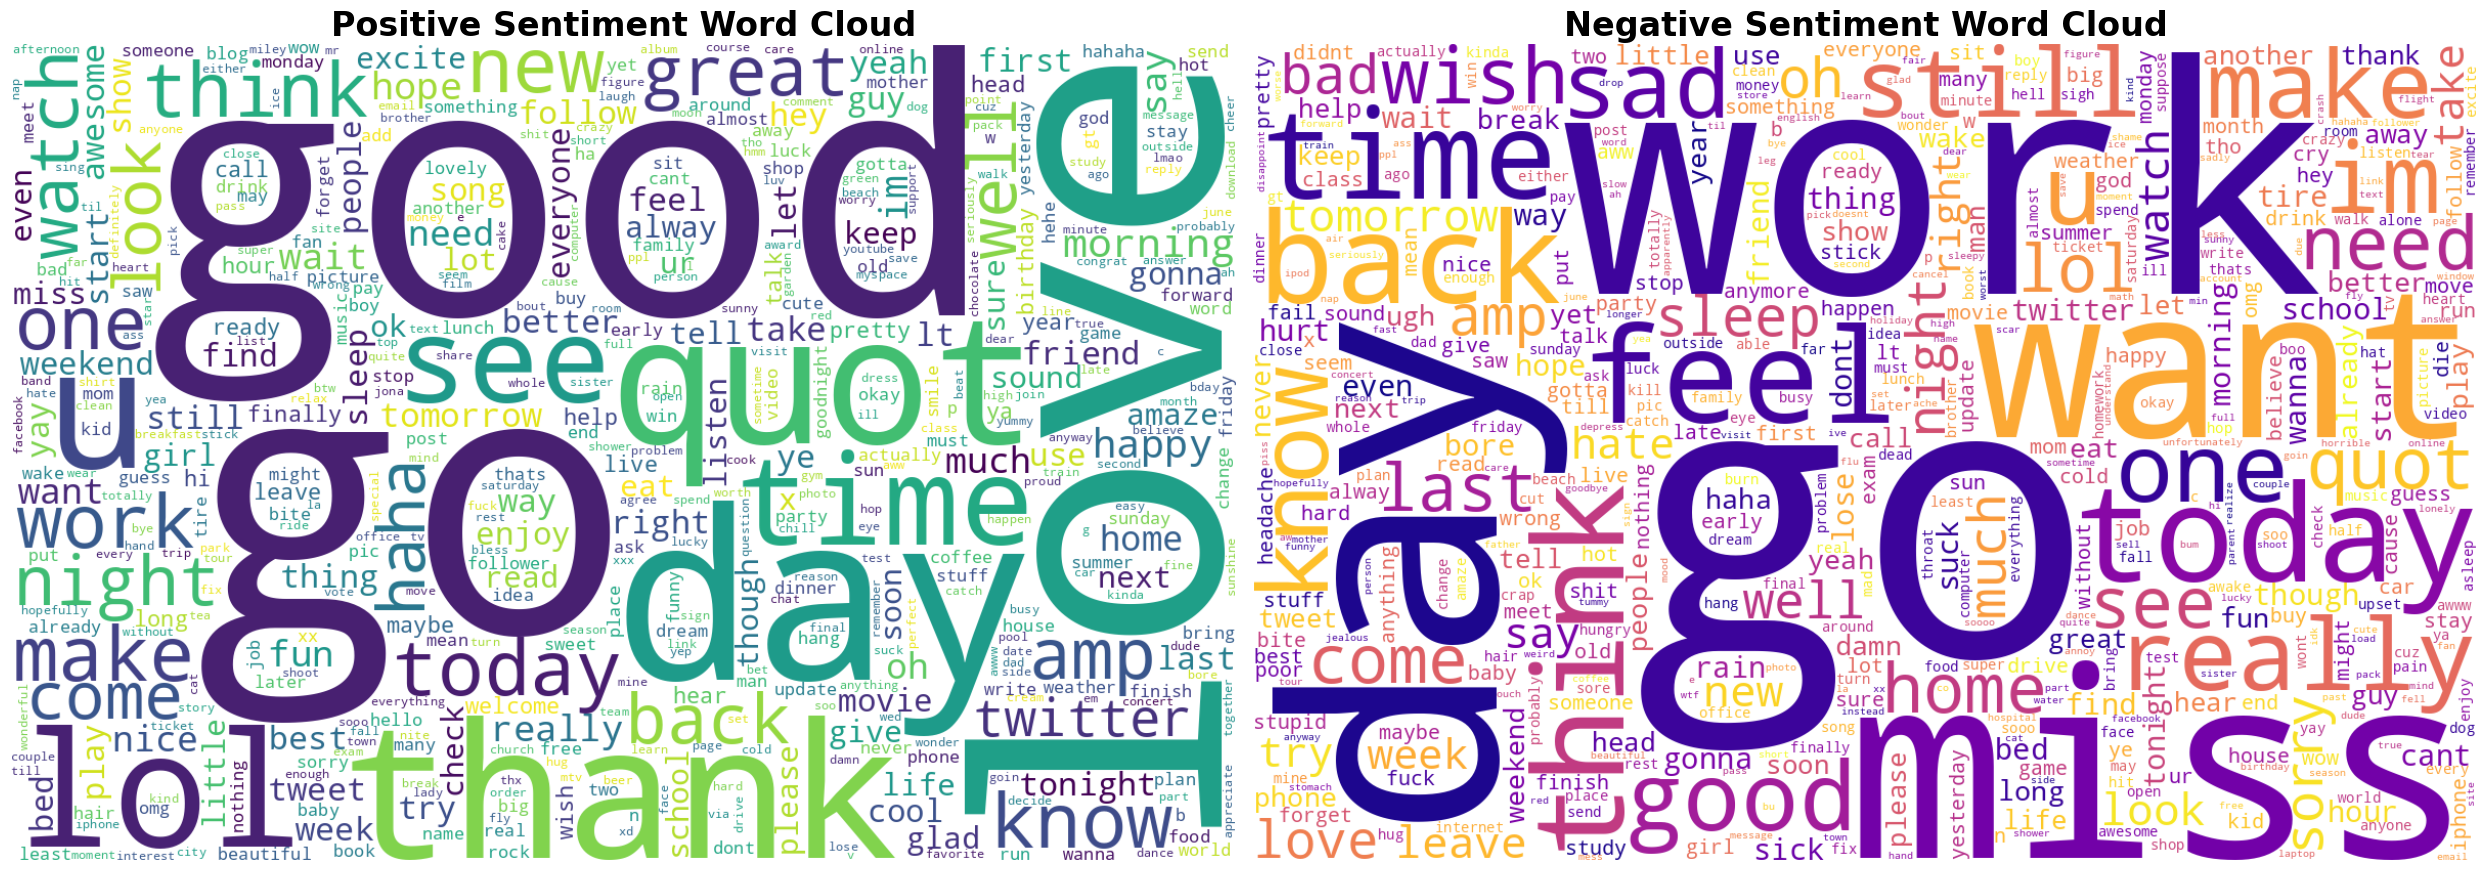

In [18]:
# تصفية بيانات المشاعر الإيجابية والسلبية
# استخراج النصوص ذات المشاعر الإيجابية فقط
positive = df[df['sentiment'] == 'Positive']['lemmatized text']
# استخراج النصوص ذات المشاعر السلبية فقط
negative = df[df['sentiment'] == 'Negative']['lemmatized text']

# دمج النصوص الإيجابية في سلسلة نصية واحدة
positive_data = " ".join(positive)
# دمج النصوص السلبية في سلسلة نصية واحدة
negative_data = " ".join(negative)

# إنشاء كائنات WordCloud للمشاعر الإيجابية والسلبية
# wc_positive تمثل سحابة الكلمات للنصوص الإيجابية
wc_positive = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='viridis',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(positive_data)

# wc_negative تمثل سحابة الكلمات للنصوص السلبية
wc_negative = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='plasma',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(negative_data)

# إنشاء مخططات فرعية لسحابة الكلمات
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# رسم سحابة الكلمات للمشاعر الإيجابية
axes[0].imshow(wc_positive, interpolation='bilinear')
axes[0].axis('off')  # إخفاء المحاور لعرض نظيف
axes[0].set_title("Positive Sentiment Word Cloud", fontsize=24, fontweight='bold')  # عنوان سحابة الكلمات الإيجابية

# رسم سحابة الكلمات للمشاعر السلبية
axes[1].imshow(wc_negative, interpolation='bilinear')
axes[1].axis('off')  # إخفاء المحاور لعرض نظيف
axes[1].set_title("Negative Sentiment Word Cloud", fontsize=24, fontweight='bold')  # عنوان سحابة الكلمات السلبية

plt.tight_layout()  # تحسين تنسيق العرض
plt.show()  # عرض المخطط


In [19]:
import nltk

# تحميل مجموعة البيانات 'punkt' من مكتبة NLTK لاستخدامها في تقسيم النصوص
nltk.download('punkt')

# حساب عدد الكلمات في النصوص المعالجة وإضافتها كعمود جديد
df['no_of_words'] = df['lemmatized text'].progress_apply(lambda document: len(document.split()))

# إنشاء ميزات جديدة لحساب عدد الأحرف في النصوص المعالجة
df['no_of_charcters'] = df['lemmatized text'].progress_apply(len)

# حساب عدد الكلمات مرة أخرى (يبدو أن هذا السطر مكرر)
df['no_of_words'] = df['lemmatized text'].progress_apply(lambda document: len(document.split()))


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
 38%|███▊      | 609149/1600000 [00:00<00:01, 837056.71it/s]

100%|██████████| 1600000/1600000 [00:01<00:00, 811280.41it/s]


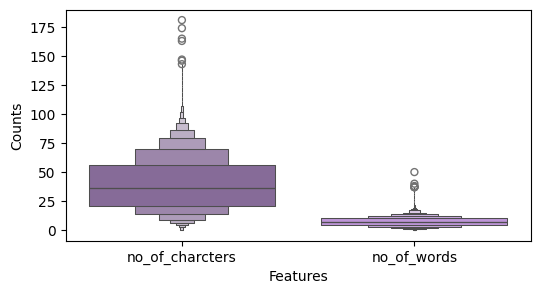

In [20]:
# رسم مخطط الصندوق (Boxplot) لعرض توزيع عدد الأحرف وعدد الكلمات
plt.figure(figsize=(6, 3))

# إنشاء لوحة ألوان داكنة لتمثيل الألوان في المخطط
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')

# رسم مخطط الصندوق لعدد الأحرف وعدد الكلمات
sns.boxenplot(df[['no_of_charcters', 'no_of_words']], palette=[colors[5], colors[8]])

# تعيين تسمية المحور السيني
plt.xlabel("Features")

# تعيين تسمية المحور الصادي
plt.ylabel("Counts")

# عرض المخطط
plt.show()


In [21]:
# Removing Outliers
df = df[(df['no_of_charcters']<100) & (df['no_of_words']<20)]

In [22]:
# تقسيم مجموعة البيانات إلى ميزات وأهداف
X = df['lemmatized text']  # الميزات (النصوص المعالجة)
y = df['sentiment'].map({"Negative": 0, "Positive": 1})  # الأهداف (تحويل المشاعر إلى أرقام)

# تقسيم البيانات إلى مجموعة تدريب (75%) ومجموعة اختبار (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


In [23]:
# نستخدم TfidfVectorizer لتحويل النصوص إلى تمثيل عددي
# نحدد "ngram_range=(1,2)" لاستخدام التمثيل الأحادي والثنائي للكلمات (مثلاً "good" و "very good")
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# نطبق fit على بيانات التدريب مع استخدام tqdm لإظهار شريط التقدم
vectorizer.fit(tqdm(X_train, desc="Vectorizing Text"))

Vectorizing Text: 100%|██████████| 1191673/1191673 [00:14<00:00, 80470.96it/s]


TfidfVectorizer(ngram_range=(1, 2))

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# تعريف النماذج المستخدمة
models = {
    "Logistic Regression": LogisticRegression(max_iter=100),  # نموذج الانحدار اللوجستي
    "Naive Bayes": MultinomialNB()  # نموذج نايف بايز
}

# قاموس لتخزين أداء النماذج
model_performance = {}

# تدريب النماذج وتقييم أدائها
for model_name, model in models.items():
    model.fit(X_train, y_train)  # تدريب النموذج على مجموعة التدريب
    
    # التنبؤات على مجموعة التدريب والاختبار
    y_train_pred = model.predict(X_train)  
    y_test_pred = model.predict(X_test)  
    
    # حساب دقة التدريب والاختبار والاسترجاع والدقة و F1 Score
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred, average='weighted')
    precision = precision_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # تخزين أداء النموذج في القاموس
    model_performance[model_name] = {
        "Training Accuracy": training_accuracy,
        "Testing Accuracy": testing_accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1 Score": f1
    }
    
    # طباعة أداء النموذج
    print(f"Model: {model_name}")
    print(f"Training Accuracy: {training_accuracy}")
    print(f"Testing Accuracy: {testing_accuracy}")
    print("--" * 20)


100%|██████████| 397225/397225 [00:05<00:00, 77250.94it/s]
